In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
seed = 1234

In [3]:
df = pd.read_csv('final_result_updated.csv')

In [4]:
df.head()

,Unnamed: 0,id,price,price/m,rooms,city,district,street,status,meters,...,market,building,material,year,adv_date,upvotes,floor,building_floors,bedroom,balcony
0,0,0,360185,4002,4,Gdańsk,Łostowice,Kryształowa,Do wykończenia,90.00,...,Pierwotny,Dom wielorodzinny,Pustak,2025,2024-03-21,766,2,2,1,Nie
1,1,1,2850000,22266,4,Sopot,Dolny,Grunwaldzka,NaN,128.00,...,Wtórny,Kamienica,Cegła,1920,2023-09-18,383,1,3,5,Nie
2,2,2,669000,16405,2,Gdynia,Redłowo,Bohaterów Starówki Warszawskiej,NaN,40.78,...,Wtórny,Blok Mieszkalny,Wielka płyta,1970,2024-02-27,309,3,9,1,Tak
3,3,3,414000,11948,2,Gdańsk,Jasień,NaN,Do wykończenia,34.65,...,Pierwotny,Blok,Wielka płyta,2023,2024-06-12,233,1,4,1,Tak
4,4,4,537365,8550,4,Gdańsk,Ujeścisko - Łostowice,NaN,Do wykończenia,62.85,...,Pierwotny,Blok,Cegła,2024,2024-06-03,230,1,3,1,Tak


### Data cleaning and preparation to the implementation of machine learning models

In [5]:
df.loc[df['district'] == 'Ujeścisko - Łostowice', 'district'] = 'Ujeścisko-Łostowice'

In [6]:
df.drop(columns=['Unnamed: 0', 'id'], inplace=True)

In [7]:
df['building'] = df['building'].str.title()

In [8]:
df['building'] = df['building'].replace('Blok Mieszkalny', 'Blok')

In [9]:
df['building'].unique()

array(['Dom Wielorodzinny', 'Kamienica', 'Blok', 'Apartamentowiec',
       'Inny', 'Wieżowiec'], dtype=object)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             2227 non-null   int64  
 1   price/m           2227 non-null   int64  
 2   rooms             2227 non-null   int64  
 3   city              2227 non-null   object 
 4   district          2227 non-null   object 
 5   street            1849 non-null   object 
 6   status            559 non-null    object 
 7   meters            2227 non-null   float64
 8   apartment_floors  2227 non-null   int64  
 9   bathroom          2227 non-null   int64  
 10  terrace           2227 non-null   object 
 11  market            2227 non-null   object 
 12  building          2227 non-null   object 
 13  material          2227 non-null   object 
 14  year              2227 non-null   int64  
 15  adv_date          2227 non-null   object 
 16  upvotes           2227 non-null   int64  


In [11]:
#deletion of columns that will be useless for the ML model
df.drop(columns=['street', 'adv_date'], inplace=True)

In [12]:
#there are some missing values that I do not want to fill with different values so I set them tu 'Unknown' and I will later encode this for ML model
df['status'].fillna('Unknown', inplace=True) 

In [13]:
#change of the values in bedroom and bathroom columns - if more than 1 bedroom/bathromm -> 'yes' else 'no'
df.loc[df['bedroom'] > 1, 'bedroom'] = 'yes'
df.loc[df['bedroom'] == 1, 'bedroom'] = 'no'
df.loc[df['bathroom'] > 1, 'bathroom'] = 'yes'
df.loc[df['bathroom'] == 1, 'bathroom'] = 'no'

In [14]:
#list of column to be encoded by LabelEncoder
to_label_encoding = ['city', 'district', 'status', 'market', 'building', 'material', 'bedroom', 'balcony', 'bathroom', 'terrace']

In [15]:
#using labelEconder
for col in to_label_encoding:
    df[col] = LabelEncoder().fit_transform(df[col])

In [16]:
#Partitioning years of building construction
df['year'] = pd.cut(df['year'],
                   [0, 1930, 1960, 1990, 2010, np.inf],
                   right=False,
                   labels=['<1930', '<1960', '<1990', '<2010', '>2010'])

In [17]:
#Since 'year' column has hierarchy I decided to use OrdinalEncoder to encode this column
to_reshape = df[['year']].values
to_reshape.reshape(-1, 1)
df['year'] = OrdinalEncoder().fit_transform(to_reshape)

In [18]:
#objects to category and change text to labels 0-1-2-3
#years to bins

In [19]:
#operations check
df.head(20)

,price,price/m,rooms,city,district,status,meters,apartment_floors,bathroom,terrace,market,building,material,year,upvotes,floor,building_floors,bedroom,balcony
0,360185,4002,4,0,12,0,90.00,2,1,1,0,2,4,4.0,766,2,2,0,0
1,2850000,22266,4,2,1,2,128.00,1,0,0,1,4,0,0.0,383,1,3,1,0
2,669000,16405,2,1,10,2,40.78,1,0,0,1,1,6,2.0,309,3,9,0,1
3,414000,11948,2,0,4,0,34.65,1,0,0,0,1,6,4.0,233,1,4,0,1
4,537365,8550,4,0,11,0,62.85,1,1,0,0,1,0,4.0,230,1,3,0,1
5,489000,16300,1,0,6,2,30.00,1,0,0,1,0,4,4.0,217,1,8,0,0
6,699840,10800,3,0,11,2,64.80,1,0,0,0,1,6,4.0,216,3,3,0,0
7,748548,10800,3,0,11,2,69.31,1,0,0,0,1,6,4.0,203,3,3,0,0
8,589000,14125,2,0,9,2,41.70,1,0,0,1,1,6,2.0,203,4,4,0,0
9,1023360,26000,1,0,13,2,39.36,1,0,0,0,1,6,4.0,203,3,3,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             2227 non-null   int64  
 1   price/m           2227 non-null   int64  
 2   rooms             2227 non-null   int64  
 3   city              2227 non-null   int32  
 4   district          2227 non-null   int32  
 5   status            2227 non-null   int32  
 6   meters            2227 non-null   float64
 7   apartment_floors  2227 non-null   int64  
 8   bathroom          2227 non-null   int32  
 9   terrace           2227 non-null   int32  
 10  market            2227 non-null   int32  
 11  building          2227 non-null   int32  
 12  material          2227 non-null   int32  
 13  year              2227 non-null   float64
 14  upvotes           2227 non-null   int64  
 15  floor             2227 non-null   int64  
 16  building_floors   2227 non-null   int64  


In [21]:
#lots of previously encoded columns need a datatype change to 'category'
to_category = ['city', 'district', 'status', 'bathroom', 'terrace', 'market', 'building', 'material', 'year', 'bedroom', 'balcony']

In [22]:
for col in to_category:
    df[col] = df[col].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             2227 non-null   int64   
 1   price/m           2227 non-null   int64   
 2   rooms             2227 non-null   int64   
 3   city              2227 non-null   category
 4   district          2227 non-null   category
 5   status            2227 non-null   category
 6   meters            2227 non-null   float64 
 7   apartment_floors  2227 non-null   int64   
 8   bathroom          2227 non-null   category
 9   terrace           2227 non-null   category
 10  market            2227 non-null   category
 11  building          2227 non-null   category
 12  material          2227 non-null   category
 13  year              2227 non-null   category
 14  upvotes           2227 non-null   int64   
 15  floor             2227 non-null   int64   
 16  building_floors   2227 n

<AxesSubplot:>

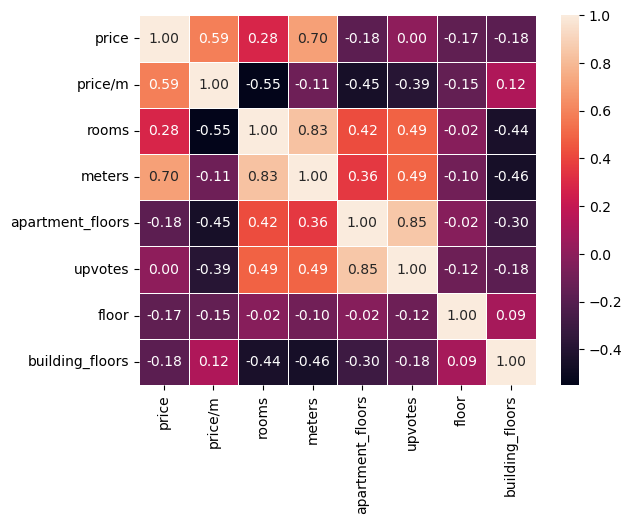

In [24]:
#check for the correlations between numeric datatypes
sns.heatmap(data=df.corr(numeric_only=True), annot=True, linewidths=0.5, fmt=".2f")

In [25]:
#Strongly correlated variables, whose removal can be considered, are: rooms (correlation with meters - 0.83) and apartment_floors (correlation with upvotes - 0.85)
#Additionally, a variable that was not detected by Pearson correlation, but common knowledge suggests removing it, is: price/m, because having the price and area already provides the same information
#After analysis, I decided to remove the column rooms. However, the variable indicating the number of floors in the apartment, which is correlated with the popularity of the listing, seems to me to be merely a result of the relatively small sample size, so I decided to keep it
df.drop(columns=['rooms', 'price/m'], inplace=True)

In [26]:
df.head()

,price,city,district,status,meters,apartment_floors,bathroom,terrace,market,building,material,year,upvotes,floor,building_floors,bedroom,balcony
0,360185,0,12,0,90.00,2,1,1,0,2,4,4.0,766,2,2,0,0
1,2850000,2,1,2,128.00,1,0,0,1,4,0,0.0,383,1,3,1,0
2,669000,1,10,2,40.78,1,0,0,1,1,6,2.0,309,3,9,0,1
3,414000,0,4,0,34.65,1,0,0,0,1,6,4.0,233,1,4,0,1
4,537365,0,11,0,62.85,1,1,0,0,1,0,4.0,230,1,3,0,1


## Building a machine learning model

#### Supervised machine learning - target variable is price

In [27]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)

#### Since the target variable is not recorded in discrete values, the chosen models will be based on regression. These include: linear regression, random forest, and KNN. The metric I will optimize is MAE (Mean Absolute Error), because the predicted values will be relatively large numbers, leading to relatively large errors during prediction. The smaller the MAE, the smaller the average error.

### Models comparison

##### The models will be compared with default parameters

In [29]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 75047.91868952283
MSE: 17716085944.35041
RMSE: 133101.78790816604
R-squared: 0.9634366608385049


In [30]:
forest = RandomForestRegressor(random_state=seed)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 925.856319569119
MSE: 78520896.57950167
RMSE: 8861.201757070068
R-squared: 0.9998379446689343


In [31]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 8588.21615798923
MSE: 3720874939.3147597
RMSE: 60998.974903802766
R-squared: 0.9923206732677283


### The best model based on MAE metric is by far the RandomForestRegressor

In [32]:
avg_price = df['price'].mean()
best_mae = 925.86

round(best_mae / avg_price * 100, 2)

0.11

##### The average prediction error using the RandomForestRegressor is approximately 0.11% of the average price of apartments from all listings, which means that for the average price from the collected dataset (846,266 PLN), the model errs by about one thousand PLN.

This result is extremely accurate, and the model does not require hyperparameter optimization.

### The most important features that influences prediction

In [33]:
importances = forest.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False) 

In [34]:
feature_imp_df

,Feature,Importance
3,meters,0.541252
0,city,0.353882
1,district,0.066637
12,floor,0.021808
13,building_floors,0.005811
11,upvotes,0.005387
8,building,0.001811
14,bedroom,0.001369
10,year,0.000948
2,status,0.000556


Text(0.5, 1.0, 'Feature Importance')

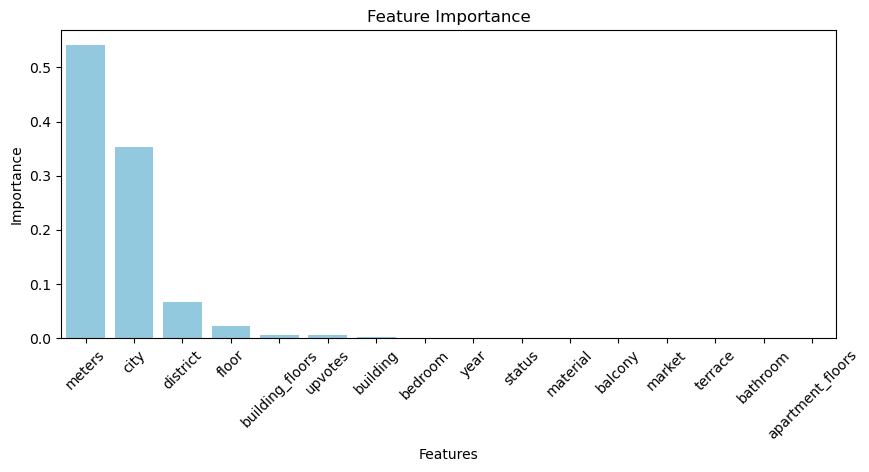

In [35]:
plt.figure(figsize=(10, 4))
sns.barplot(data=feature_imp_df, x='Feature', y='Importance', color='skyblue')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.title('Feature Importance')

### To the most important features we can list: area (square meters), city, district, floor

##### Here is the new RandomForestRegressor containing only the most important features to compare with the original model

In [36]:
X = df.loc[:, ['meters', 'city', 'district', 'floor']]
y = df.loc[:, 'price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [38]:
new_forest = RandomForestRegressor(random_state=seed)
new_forest.fit(X_train, y_train)

y_pred = new_forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mae:', mae)
print('r2:', r2)

mae: 991.7996768402145
r2: 0.9997986558240323


In [39]:
round(mae/avg_price * 100, 2)

0.12

#### The average error of the model containing only the 4 most important variables is worse than the original model by just 0.01% of the average property prices. This is definitely an acceptable error, making it easier to input new listings into the system for predicting prices for future users.

In [40]:
city_mapper = {'Gdańsk' : 0, 'Gdynia' : 1, 'Sopot' : 2}
district_mapper = {'Łostowice': 12, 'Dolny': 1, 'Redłowo': 10, 'Jasień': 4,
       'Morena': 6, 'Ujeścisko-Łostowice': 11, 'Przymorze': 9, 'Śródmieście': 13,
       'Cisowa': 0, 'Grunwaldzka': 3, 'Dąbrowa': 2, 'Kamienna Góra': 5,
       'Piecki-Migowo': 8, 'Orunia Górna': 7}

# Here one can implement the most important features of the sale offer and get price prediction

### Acceptable cities are: Gdańsk, Gdynia, Sopot

### Acceptable districts are: Łostowice, Dolny, Redłowo, Jasień, Morena, Ujeścisko-Łostowice, Przymorze, Śródmieście, Cisowa, Grunwaldzka, Dąbrowa, Kamienna Góra, Piecki-Migowo, Orunia Górna

In [41]:
new_records = {'meters': 38, 'city': city_mapper['Gdańsk'], 'district': district_mapper['Przymorze'], 'floor': 3}
to_pred = pd.DataFrame(data=new_records, index=[0])
y_pred = new_forest.predict(to_pred)
print(y_pred[0])

595820.0


For this example, I implemented a different sale offer from a different website. The real sale offer price is 585,000 PLN. Thus, if we assume the model is well-trained, the real offer is 10,000 PLN cheaper than it is supposed to be based on the parameters. Therefore, we could consider taking a closer look at the offer if we are looking to buy an apartment.

In [42]:
#Saving data with only the most important parameters to another csv file for building UI in the future
df = df[['price', 'meters', 'city', 'district', 'floor']]
df.to_csv('machine_learning_data.csv')